In [130]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d
import os

A = 'd'
B='Au'
sqrts = 200
cen = '40-60'
system = A+B+str(sqrts)+'/'+cen

channels = ['qqg', 'qgq', 
            'ccg', 'cgc',
            'bbg', 'bgb',
            'ggg', 'gqq', 'gcc', 'gbb']

gs = [1.6,1.8,2.0]

fformat = "/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/{system}/g-{g}/STQ/{channel}-cut2-{M}.dat"

NE, NkT, Nx = 10, 100, 100
shape = (NE, NkT, Nx)

spad = 2.

CA = 3.
CF = 4./3.
TR = .5

Mc = 1.3
Mb = 4.5

def scale(ch, x, kT):
    kT2 = kT**2
    T = 1/kT2
    
    if ch=='qqg':
        L = CF*(1.+(1-x)**2)/x
    if ch=='qgq':
        L = CF*(1.+x**2)/(1-x)
    if ch=='ggg':
        L = CA*(1.+(1-x)**4+x**4)/x/(1-x)
    if ch=='gqq':
        L = TR*(x**2+(1-x)**2)
    if ch=='ccg':
        M2 = Mc**2
        Q2 = (kT2+x**2*M2)/(x*(1-x))
        L = CF*((1.+(1-x)**2)/x - 2.*M2/Q2)
    if ch=='cgc':
        M2 = Mc**2
        Q2 = (kT2+(1-x)**2*M2)/(x*(1-x))
        L = CF*((1.+x**2)/(1-x) - 2.*M2/Q2)
    if ch=='gcc':
        M2 = Mc**2
        Q2 = (kT2+M2)/(x*(1-x))
        L = TR*(x**2+(1-x)**2 + 2*M2/Q2)
    if ch=='bbg':
        M2 = Mb**2
        Q2 = (kT2+x**2*M2)/(x*(1-x))
        L = CF*((1.+(1-x)**2)/x - 2.*M2/Q2)
    if ch=='bgb':
        M2 = Mb**2
        Q2 = (kT2+(1-x)**2*M2)/(x*(1-x))
        L = CF*((1.+x**2)/(1-x) - 2.*M2/Q2)
    if ch=='gbb':
        M2 = Mb**2
        Q2 = (kT2+M2)/(x*(1-x))
        L = TR*(x**2+(1-x)**2 + 2*M2/Q2)
        
    return np.outer(T, L)


def scale2(ch, x, kT):
    return scale(ch, np.array([x]), np.array([kT]) )[0,0]

# Load all data

Pij = {'Grids': None, 'Pij':{}}
for ch in channels:
    Pij['Pij'][ch] = []
    for g in gs:
        M=0.0
        if 'c' in ch:
            M=Mc
        if 'b' in ch:
            M=Mb
        print(ch)
        nch = ch.replace('c','q').replace('b','q')
        print(nch)
        fname = fformat.format(channel=nch,g=g,system=system,M=M)
        print(fname)
        e, kT, x, P = np.loadtxt(fname, usecols=[0,1,2,3],skiprows=1).T
        e = e.reshape(*shape)
        kT = kT.reshape(*shape)
        x = x.reshape(*shape)
        P = P.reshape(*shape)         
        if Pij['Grids'] == None:
            Pij['Grids'] = {'e':e[:,0,0], 'kT':kT[0,:,0], 'xmin':.2/e[:,0,0], 'xmax':[.99]*len(e[:,0,0])}
        Pij['Pij'][ch].append(P)

qqg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.6/STQ/qqg-cut2-0.0.dat
qqg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.8/STQ/qqg-cut2-0.0.dat
qqg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-2.0/STQ/qqg-cut2-0.0.dat
qgq
qgq
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.6/STQ/qgq-cut2-0.0.dat
qgq
qgq
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.8/STQ/qgq-cut2-0.0.dat
qgq
qgq
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-2.0/STQ/qgq-cut2-0.0.dat
ccg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.6/STQ/qqg-cut2-1.3.dat
ccg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-1.8/STQ/qqg-cut2-1.3.dat
ccg
qqg
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-60/g-2.0/STQ/qqg-cut2-1.3.dat
cgc
qgq
/home/weiyaoke/Documents/SplittingFunctionOutput-TcCut/dAu200/40-

In [132]:
offormat = "/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/{system}/g-{g}/{type}{channel}.dat"


In [133]:
# make interpolators
IPij = {ch:[] for ch in channels}


for ch in channels:
    IPij[ch] = []
    for ig, g in enumerate(gs):
        IPij[ch].append([])
        for ie, e in enumerate(Pij['Grids']['e']):
            x = np.exp(np.linspace(np.log(Pij['Grids']['xmin'][ie]), np.log(Pij['Grids']['xmax'][ie]), Nx))
            kT = Pij['Grids']['kT']
            data = Pij['Pij'][ch][ig][ie,:,:]
            f = interp2d(np.log(kT), np.log(x[:]), (data[:,:]/scale(ch, x, kT)).T, 
                         kind='linear', fill_value=0.0, bounds_error=False)
            IPij[ch][ig].append(f)
            

In [134]:
# plot representative values of Pij
def make_fig(iEs, iKs):
    fig, axes = plt.subplots(nrows=len(iEs), ncols=len(iKs), 
                             figsize=(len(iKs)*spad, len(iEs)*spad), 
                             sharex=True, sharey=True)
    return fig, axes
def single_plot(axes, iEs, iKs, ch, ig, color='b'):
    for row, ie in zip(axes, iEs):
        for ax, kT in zip(row, iKs):
            e = Pij['Grids']['e'][ie]
            kT2 = kT**2
            xmin = kT/2./e
            xx = np.linspace(xmin, 1.-xmin, 501)
            if ch in ['ggg', 'gqq','gcc','gbb']:
                xi = np.concatenate([xx[xx<=.5], 1.-xx[xx>.5]])
                yy = np.array([IPij[ch][ig][ie](np.log(kT), it)[0] for it in np.log(xi)])
            elif ch=='qqg':
                y1 = np.array([IPij['qqg'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['qgq'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            elif ch=='ccg':
                y1 = np.array([IPij['ccg'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['cgc'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            elif ch=='bbg':
                y1 = np.array([IPij['bbg'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['bgb'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            elif ch=='qgq':
                y1 = np.array([IPij['qgq'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['qqg'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            elif ch=='cgc':
                y1 = np.array([IPij['cgc'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['ccg'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            elif ch=='bgb':
                y1 = np.array([IPij['bgb'][ig][ie](np.log(kT), it)[0] for it in np.log(xx[xx<=.5])])
                y2 = np.array([IPij['bbg'][ig][ie](np.log(kT), it)[0] for it in np.log(1.-xx[xx>.5])])
                yy = np.concatenate([y1, y2])
            else:
                yy=0
            
            yy *= scale(ch, xx, kT)[0]
            ax.plot(xx, yy, color=color, alpha=.6)
            ax.semilogy()
            ax.set_ylim(1e-4,1e2)
            if ax.get_subplotspec().is_last_col():
                ax2 = ax.twinx()
                ax2.set_yticks([])
                ax2.set_ylabel(r"$E={e:1.1f}$ GeV".format(e=e))
            if ax.get_subplotspec().is_first_row():
                ax2 = ax.twiny()
                ax2.set_xticks([])
                ax2.set_xlabel(r"$k_T={kT:1.2f}$ GeV".format(kT=kT))

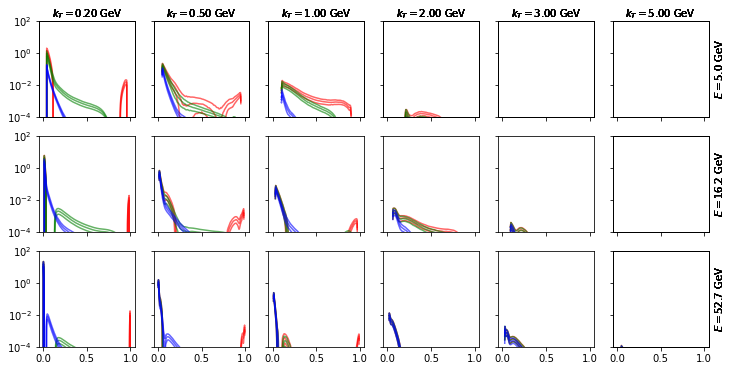

In [135]:
iEs, iKs = [0,2,4],[.2,.5, 1., 2., 3., 5]
fig, axes = make_fig(iEs, iKs)
for ch, color in zip(['qqg','ccg','bbg'],'rgb'):
    for ig,g in enumerate(gs):
        M=0.0
        if 'c' in ch:
            M=Mc
        if 'b' in ch:
            M=Mb
        nch = ch.replace('c','q').replace('b','q')
        fname = fformat.format(channel=nch,g=g,system=system,M=M)
        e, kT, x, P = np.loadtxt(fname, usecols=[0,1,2,3],skiprows=1).T
        e = e.reshape(*shape)
        kT = kT.reshape(*shape)
        x = x.reshape(*shape)
        P = P.reshape(*shape) 
        single_plot(axes, iEs, iKs, ch, ig, color=color)
        #plt.semilogy()

In [136]:
# Now that we have the interpolator,
# output grid with the following decomposition: a total of seven tables
# gqq -> qgg type A
# qqg -> qqg type A
# qgq -> R(x) and D --> qgq = R(x)/[(1-x)_+] + D delta(1-x)
# ggg -> R(x), A(x) and D --> qgg = R(x)/[(1-x)_+] + A(x) + D delta(1-x)

In [137]:
# Here: 

# GQQ
# A_gqq = gqq(x)

# QQG
# A_qqg = qqg(x)

# QGQ
# R_qgq(x) = (1-x) * qgq(x)
# D_qgq(x) = - int_0^1 (R_qgq(x) - R_qgq(1))/(1-x) dx

# GGG
# R_ggg(x) = x(1-x) * ggg(x)
# A_ggg(x) = (1-x) * ggg(x)
# D_ggg(x) = - int_0^1 (R_ggg(x) - R_ggg(1))/(1-x) dx
Pij['Grids']['e']

array([   5.        ,    9.00824115,   16.22968174,   29.24017738,
         52.68051384,   94.91175456,  170.99759467,  308.07751388,
        555.04730778, 1000.        ])

In [138]:
# output A table 
# we will output table A_gqq
from fortranformat import FortranRecordWriter
line = FortranRecordWriter('(1E11.4)\n')
for ch in ['gqq','gcc','gbb']:
    for ig, g in enumerate(gs):
        fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='A')
        os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        with open(fname, 'w') as f:
            for ie, E in enumerate(Pij['Grids']['e']):
                lnkTmin = np.log(.2)
                lnkTmax = np.log(1000.)
                newkT = np.exp(np.linspace(lnkTmin, lnkTmax, 101))
                for kT in newkT:
                    xmin = .2/1000.
                    xmax = 1. - .2/1000.
                    umin = np.log(xmin/(1-xmin))
                    umax = np.log(xmax/(1-xmax))
                    #print(umin, umax, kT)
                    u = np.linspace(umin, umax, 101)
                    newX = 1/(1+np.exp(-u))
                    for x in newX:
                        xx = x if x<.5 else 1.-x
                        item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(xx))[0] * scale2(ch, x, kT)
                        f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))


In [139]:
# output A table 
# we will output table A_qqg
from fortranformat import FortranRecordWriter
line = FortranRecordWriter('(1E11.4)\n')
for ch in ['qqg','ccg','bbg']:
    for ig, g in enumerate(gs):
        fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='A')
        os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        with open(fname, 'w') as f:
            for ie, E in enumerate(Pij['Grids']['e']):
                lnkTmin = np.log(.2)
                lnkTmax = np.log(1000.)
                newkT = np.exp(np.linspace(lnkTmin, lnkTmax, 101))
                for kT in newkT:
                    xmin = .2/1000.
                    xmax = 1. - .2/1000.
                    umin = np.log(xmin/(1-xmin))
                    umax = np.log(xmax/(1-xmax))
                    #print(umin, umax, kT)
                    u = np.linspace(umin, umax, 101)
                    newX = 1/(1+np.exp(-u))
                    for x in newX:
                        if x<.5:
                            item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(x))[0] * scale2(ch, x, kT)
                            f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))
                        else:
                            nch = ch[0]+ch[2]+ch[1]
                            item = kT**2*IPij[nch][ig][ie](np.log(kT), np.log(1.-x))[0] * scale2(nch, 1-x, kT)
                            f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))

In [140]:
# output A table 
# we will output table A_ggg
from fortranformat import FortranRecordWriter
line = FortranRecordWriter('(1E11.4)\n')
ch = 'ggg'
for ig, g in enumerate(gs):
    fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='A')
    os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
    with open(fname, 'w') as f:
        for ie, E in enumerate(Pij['Grids']['e']):
            lnkTmin = np.log(.2)
            lnkTmax = np.log(1000.)
            newkT = np.exp(np.linspace(lnkTmin, lnkTmax, 101))
            for kT in newkT:
                xmin = .2/1000.
                xmax = 1. - .2/1000.
                umin = np.log(xmin/(1-xmin))
                umax = np.log(xmax/(1-xmax))
                #print(umin, umax, kT)
                u = np.linspace(umin, umax, 101)
                newX = 1/(1+np.exp(-u))
                for x in newX:
                    if x<.5:
                        item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(x))[0] * scale2(ch, x, kT)
                    else:
                        item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(1.-x))[0] * scale2(ch, 1.-x, kT)
                    P0 = (1+x**4+(1-x)**4)/x/(1-x)
                    item = item/P0*2*( (1-x)/x  + x*(1-x) )
                    f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))


In [141]:
# output R table 
# we will output table R_ggg
from fortranformat import FortranRecordWriter
line = FortranRecordWriter('(1E11.4)\n')
ch = 'ggg'
for ig, g in enumerate(gs):
    fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='R')
    os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
    with open(fname, 'w') as f:
        for ie, E in enumerate(Pij['Grids']['e']):
            lnkTmin = np.log(.2)
            lnkTmax = np.log(1000.)
            newkT = np.exp(np.linspace(lnkTmin, lnkTmax, 101))
            for kT in newkT:
                xmin = .2/1000.
                xmax = 1. - .2/1000.
                umin = np.log(xmin/(1-xmin))
                umax = np.log(xmax/(1-xmax))
                #print(umin, umax, kT)
                u = np.linspace(umin, umax, 101)
                newX = 1/(1+np.exp(-u))
                for x in newX:
                
                    if x<.5:
                        item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(x))[0] * scale2(ch, x, kT)
                    else:
                        item = kT**2*IPij[ch][ig][ie](np.log(kT), np.log(1.-x))[0] * scale2(ch, 1.-x, kT)
                    P0 = (1+x**4+(1-x)**4)/x/(1-x)
                    item = item/P0*2*x
                    f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))

In [142]:
# output R table 
# we will output table R_qgq
from fortranformat import FortranRecordWriter
line = FortranRecordWriter('(1E11.4)')
for ch in ['qgq','cgc','bgb']:
    for ig, g in enumerate(gs):
        fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='R')
        os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        with open(fname, 'w') as f:
            for ie, E in enumerate(Pij['Grids']['e']):
                lnkTmin = np.log(.2)
                lnkTmax = np.log(1000.)
                newkT = np.exp(np.linspace(lnkTmin, lnkTmax, 101))
                for kT in newkT:
                    xmin = .2/1000.
                    xmax = 1. - .2/1000.
                    umin = np.log(xmin/(1-xmin))
                    umax = np.log(xmax/(1-xmax))
                    #print(umin, umax, kT)
                    u = np.linspace(umin, umax, 101)
                    newX = 1/(1+np.exp(-u))
                    for x in newX:
                        if x>.5:
                            nch = ch[0]+ch[2]+ch[1]
                            item = kT**2*(1.-x)*IPij[nch][ig][ie](np.log(kT), np.log(1.-x))[0] * scale2(nch, 1.-x, kT)
                            f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))
                        else:
                            item = kT**2*(1-x)*IPij[ch][ig][ie](np.log(kT), np.log(x))[0] * scale2(ch, x, kT)
                            f.write("{:1.7f} {:1.7f} {:1.7f} {:1.7f}\n".format(E, kT, x, item))

In [143]:
# output D table 
# we will output table D_ggg
ch = 'ggg'
for ig, g in enumerate(gs[:]):
    fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='D')
    os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
    print(fname)
    with open(fname,'w') as f:
        for ie, E in enumerate(Pij['Grids']['e']):
            Q = np.exp(np.linspace(np.log(.2), np.log(1000.),101))
            df = IPij['ggg'][ig][ie]
            xmin, xmax = .2/1000., 1-.2/1000.
            ymin = -np.log(1-xmin)
            ymax = -np.log(1-xmax)
            for q in Q:
                def func(y):
                    res = 0.
                    x = 1 - np.exp(-y)
                    kT = np.sqrt(x*(1-x)*q**2)
                    lnkT = np.log(kT)
                    kT2 = kT**2
                    if x>.5:
                        Pij = scale2('ggg', 1.-x, kT)*df(lnkT, np.log(1.-x))[0]
                    else:
                        Pij = scale2('ggg', x, kT)*df(lnkT, np.log(x))[0]
                    res = - kT2*Pij*x*(1-x)
                    return res
                item, err = quad(func, ymin, ymax, epsrel=.01)
                #print(E, q, item, " * (1+/-", err/(1e-9+abs(item)),")")
                f.write("{:1.7f} {:1.7f} {:1.7f}\n".format(E, q, item))

/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dgg.dat


/tmp/ipykernel_4600/901287503.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  item, err = quad(func, ymin, ymax, epsrel=.01)
/tmp/ipykernel_4600/901287503.py:28: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  item, err = quad(func, ymin, ymax, epsrel=.01)


/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dgg.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dgg.dat


In [144]:
# output D table 
# we will output table D_ggg
for ch in ['gqq', 'gcc', 'gbb']:
    M = 0.0
    if 'c' in ch:
        M=Mc
    if 'b' in ch:
        M=Mb   
    for ig, g in enumerate(gs[:]):
        fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='D')
        os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        print(fname)
        with open(fname,'w') as f:
            for ie, E in enumerate(Pij['Grids']['e']):
                Q = np.exp(np.linspace(np.log(.2), np.log(1000.),101))
                xmin, xmax = .2/1000., 1-.2/1000.
                ymin = -np.log(1-xmin)
                ymax = -np.log(1-xmax)
                for q in Q:
                    def func(y):
                        res = 0.
                        x = 1 - np.exp(-y)
                        kT = np.sqrt(x*(1-x)*q**2)
                        lnkT = np.log(kT)
                        kT2 = kT**2
                        if x>.5:         
                            Pij2 = scale2(ch, 1.-x, kT)*IPij[ch][ig][ie](lnkT, np.log(1.-x))[0]
                        else:
                            Pij2 = scale2(ch, x, kT)*IPij[ch][ig][ie](lnkT, np.log(x))[0]
                        res = - kT2*(2*x*Pij2)*(1-x)
                        return res
                    item, err = quad(func, ymin, ymax, epsrel=.01)
                    #print(E, q, item, " * (1+/-", err/(1e-9+abs(item)),")")
                    f.write("{:1.7f} {:1.7f} {:1.7f}\n".format(E, q, item))

/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dgq.dat


/tmp/ipykernel_4600/3672575683.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  item, err = quad(func, ymin, ymax, epsrel=.01)
/tmp/ipykernel_4600/3672575683.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  item, err = quad(func, ymin, ymax, epsrel=.01)


/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dgq.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dgq.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dgc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dgc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dgc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dgb.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dgb.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dgb.dat


In [145]:
# output D table 
# we will output table D_qgq
for ch in ['qgq','cgc','bgb']:
    M = 0.0
    if 'c' in ch:
        M=Mc
    if 'b' in ch:
        M=Mb        
    for ig, g in enumerate(gs[:]):
        fname = offormat.format(system=system, g=g, channel=ch[0]+ch[-1], type='D')
        os.makedirs('/'.join(fname.split('/')[:-1]), exist_ok=True)
        print(fname)
        with open(fname,'w') as f:
            for ie, E in enumerate(Pij['Grids']['e']):
                #print(E)
                Q = np.exp(np.linspace(np.log(.2), np.log(1000.),101))
                xmin, xmax = .2/1000., 1-.2/1000.
                ymin = -np.log(1-xmin)
                ymax = -np.log(1-xmax)
                for q in Q:
                    def func(y):
                        x = 1 - np.exp(-y)
                        kT2 = x*(1-x)*q**2-(1-x)**2*M**2
                        if (kT2<0): 
                            return 0
                        kT = np.sqrt(kT2)
                        lnkT = np.log(kT)
                        kT2 = kT**2
                        if x>.5:
                            nch = ch[0]+ch[2]+ch[1]
                            Pij = scale2(nch, 1.-x, kT)*IPij[nch][ig][ie](lnkT, np.log(1.-x))[0]
                        else:
                            Pij = scale2(ch, x, kT)*IPij[ch][ig][ie](lnkT, np.log(x))[0]

                        return - kT2 * Pij * (1-x)
                    item, err = quad(func, ymin, ymax, epsrel=.01)
                    #print(E, q, item, " * (1+/-", err/(1e-9+abs(item)),")")
                    f.write("{:1.7f} {:1.7f} {:1.7f}\n".format(E, q, item))

/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dqq.dat


/tmp/ipykernel_4600/3006391328.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  item, err = quad(func, ymin, ymax, epsrel=.01)
/tmp/ipykernel_4600/3006391328.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  item, err = quad(func, ymin, ymax, epsrel=.01)


/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dqq.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dqq.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dcc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dcc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dcc.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.6/Dbb.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-1.8/Dbb.dat
/home/weiyaoke/Documents/SplittingDecomposedGirdCXX-TcCut/dAu200/40-60/g-2.0/Dbb.dat
